<a href="https://colab.research.google.com/github/nunival/462-Computer-Vision/blob/main/Using_APIs_for_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3 - Create a Notebook that Uses API calls
***
In this notebook I make use of Microsoft Azure's API for their Cognative Services. 
<br><br>
The first step is to create a computer vision resource within the Azure platform. Once you do this you can pass the subscription key and endpoint for authentication then use any of the API service. 
<br><br>
Here I highlight the functionality of the following:
1. Reading handwritten text
2. Finding brands in an image
3. Identifying celebrities
4. Finding faces
5. Identifying tags


For additional resources see the [Microsoft documentation.](https://docs.microsoft.com/en-us/azure/cognitive-services/computer-vision/quickstarts-sdk/image-analysis-client-library?tabs=visual-studio&pivots=programming-language-python)

## Set Up
Installing packages and dependencies

In [ ]:
pip install --upgrade azure-cognitiveservices-vision-computervision

     |████████████████████████████████| 92kB 4.3MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 


In [ ]:
pip install pillow

In [ ]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

from array import array
import os
from PIL import Image
import sys
import time

'''
Authenticate
Authenticates your credentials and creates a client.
'''
subscription_key = "ENTER_YOUR_KEY_HERE"
endpoint = "ENTER_YOUR_ENDPOINT_HERE"

In [ ]:
# Authenticating with your credentials
computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

## 1. Reading handwritten images

Below is the image we're passing to the model to read:
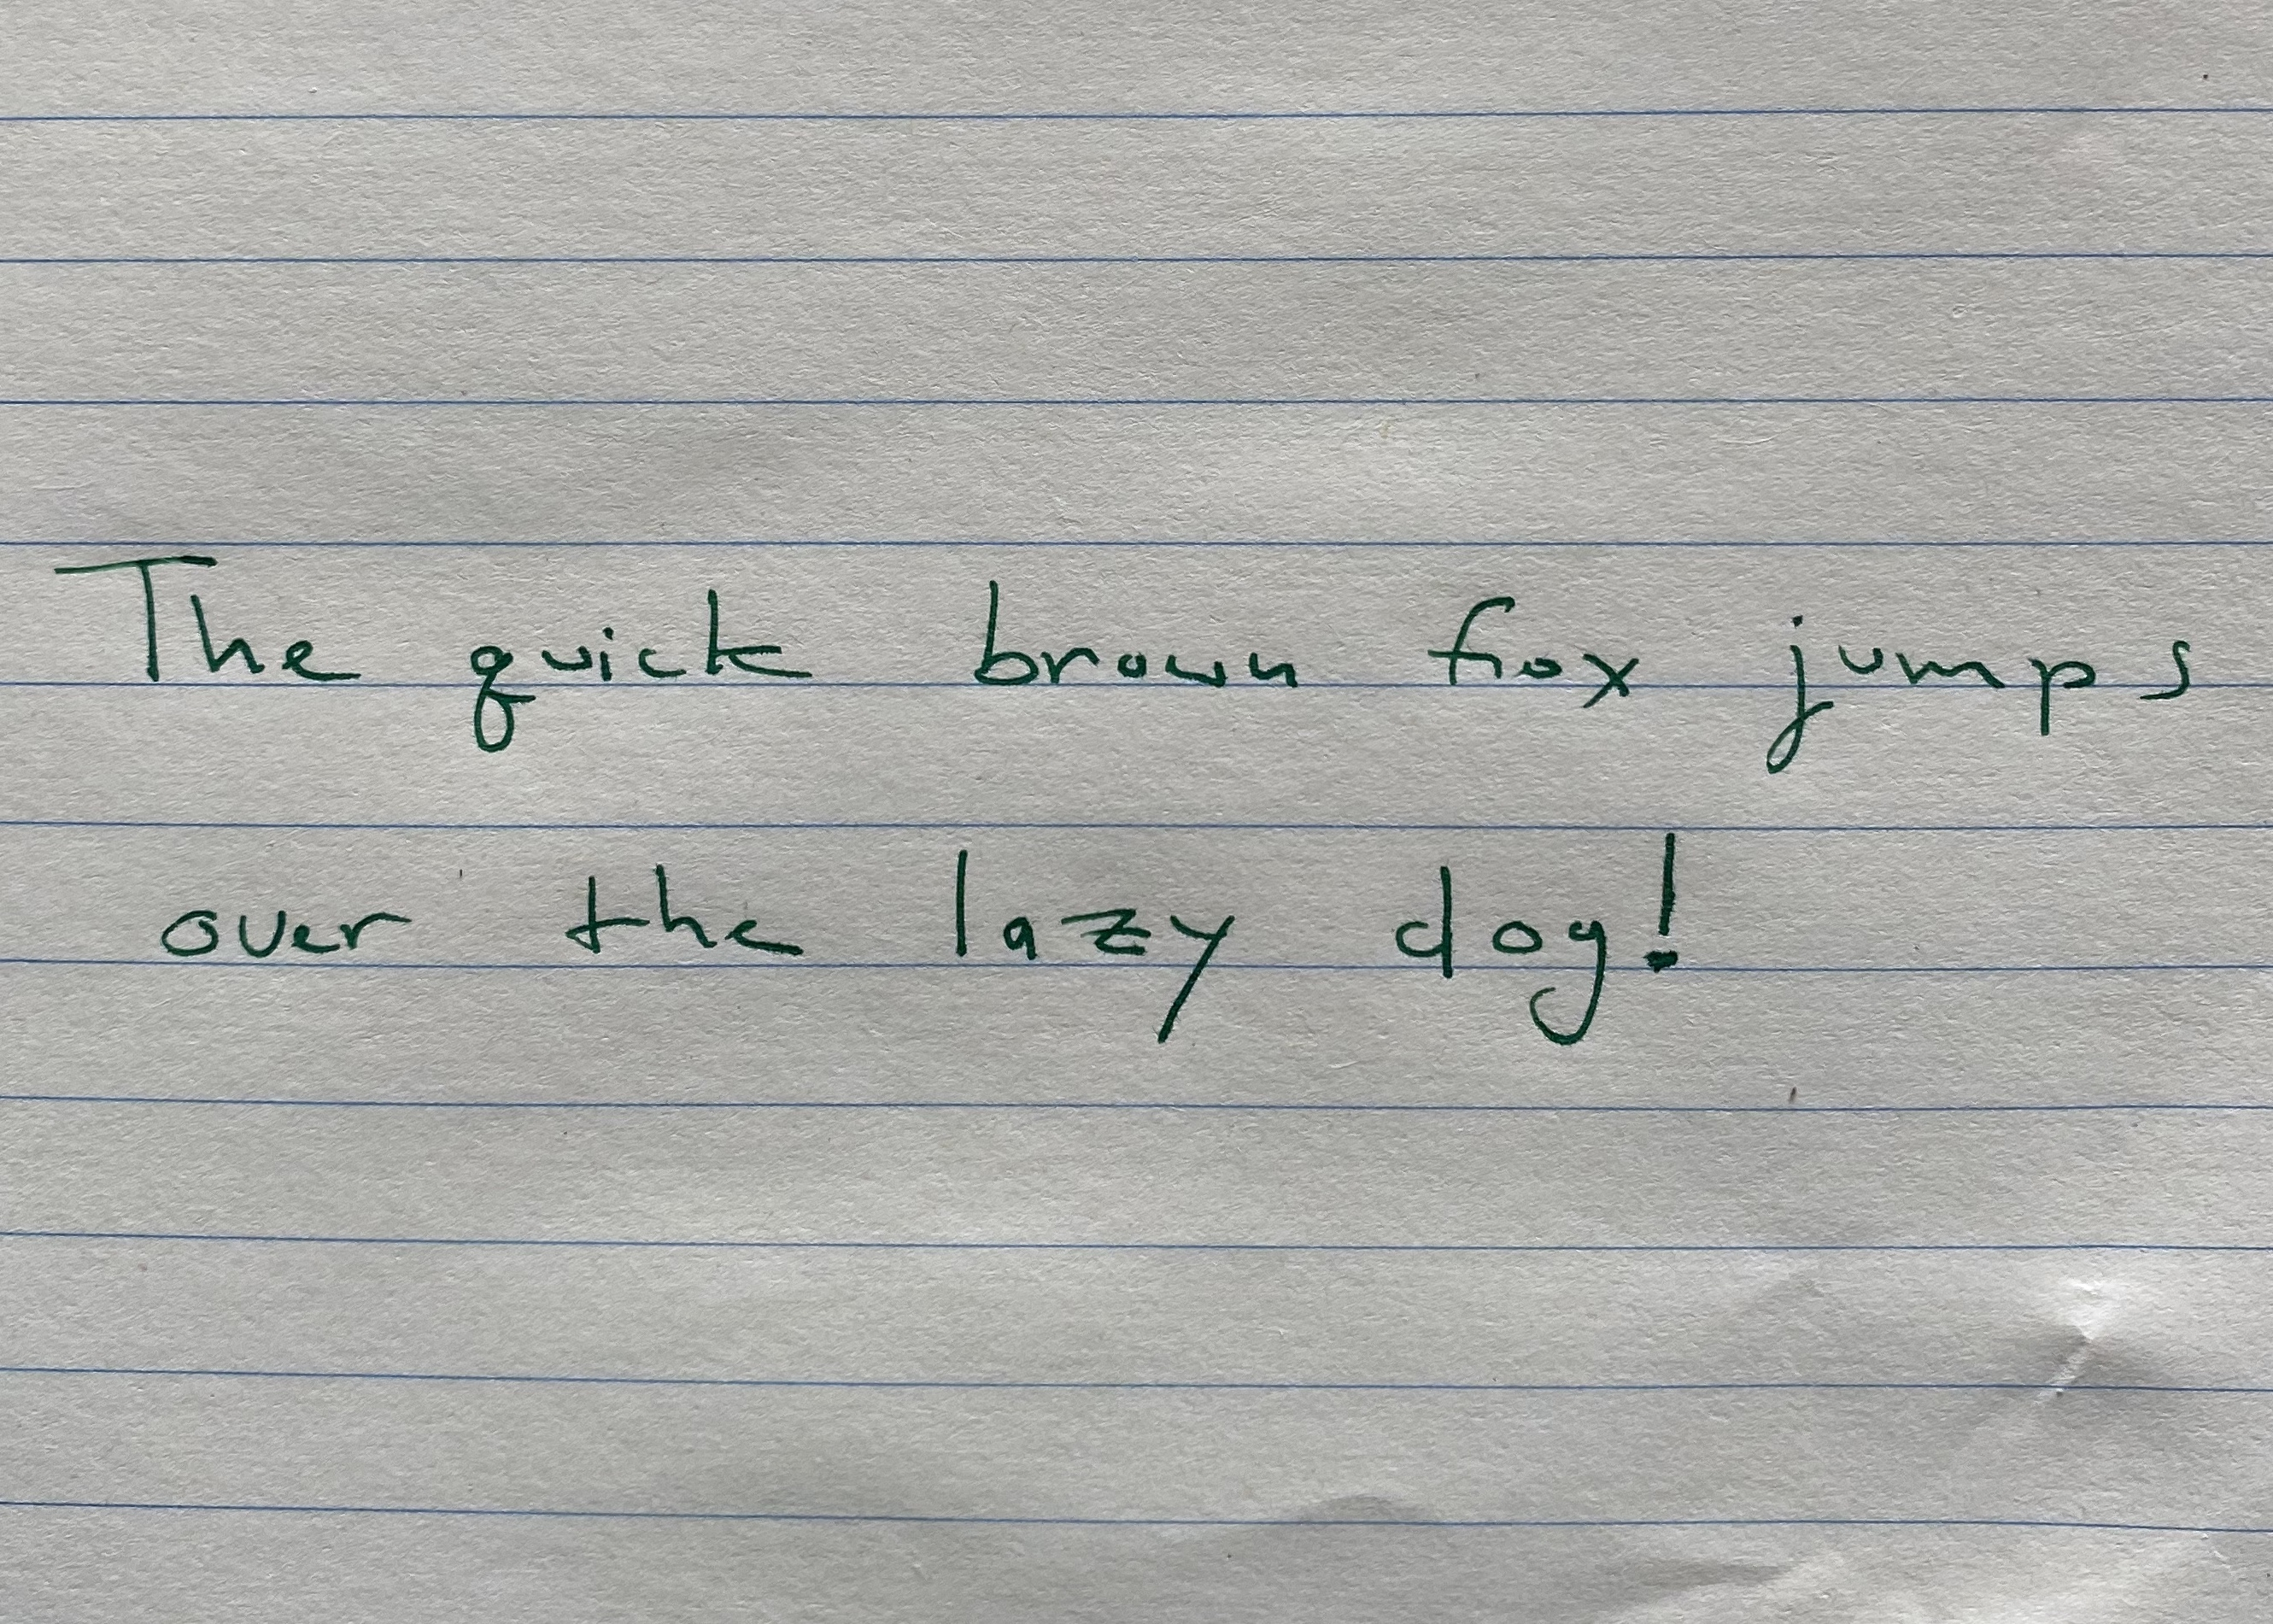

In [27]:
'''
Batch Read File, recognize handwritten text - remote
This example will extract handwritten text in an image, then print results, line by line.
This API call can also recognize handwriting (not shown).
'''
print("===== Batch Read File - remote =====")
# Get an image with handwritten text
remote_image_handw_text_url = "https://raw.githubusercontent.com/MicrosoftDocs/azure-docs/master/articles/cognitive-services/Computer-vision/Images/readsample.jpg"

# Call API with URL and raw response (allows you to get the operation location)
recognize_handw_results = computervision_client.read(remote_image_handw_text_url,  raw=True)

===== Batch Read File - remote =====


In [ ]:
# Get the operation location (URL with an ID at the end) from the response
operation_location_remote = recognize_handw_results.headers["Operation-Location"]
# Grab the ID from the URL
operation_id = operation_location_remote.split("/")[-1]

# Call the "GET" API and wait for it to retrieve the results 
while True:
    get_handw_text_results = computervision_client.get_read_result(operation_id)
    if get_handw_text_results.status not in ['notStarted', 'running']:
        break
    time.sleep(1)

# Print the detected text, line by line
if get_handw_text_results.status == OperationStatusCodes.succeeded:
    for text_result in get_handw_text_results.analyze_result.read_results:
        for line in text_result.lines:
            print(line.text)
            print(line.bounding_box)
print()

The quick brown fox jumps
[38.0, 650.0, 2572.0, 699.0, 2570.0, 854.0, 37.0, 815.0]
Over
[184.0, 1053.0, 508.0, 1044.0, 510.0, 1123.0, 184.0, 1128.0]
the lazy dog!
[639.0, 1011.0, 1976.0, 1026.0, 1974.0, 1158.0, 637.0, 1141.0]



## 2. Checking for Brands in an image
The API has the ability to analyze images as well. You can check them for brand names, Adult content, faces, and a whole bunch of other things. 
<br><br>
In this example we're testing the ability to identify a brand.

Image we're using:
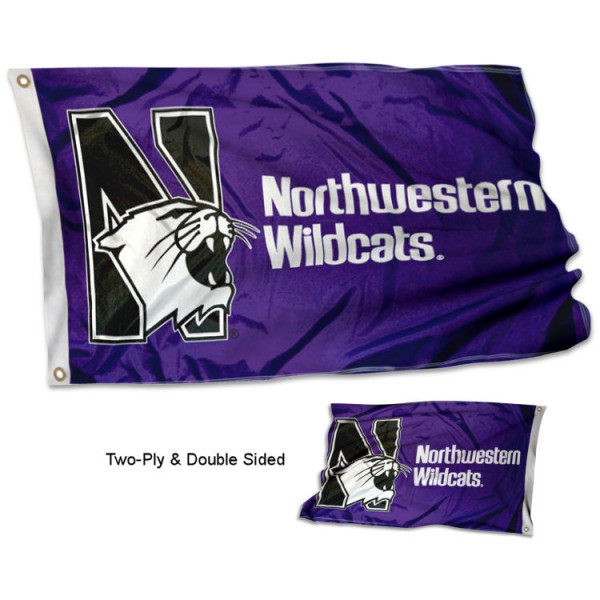

In [ ]:
'''
Detect Brands - remote
This example detects common brands like logos and puts a bounding box around them.
'''
print("===== Detect Brands - remote =====")
# Get a URL with a brand logo
remote_image_url = "https://www.collegeshade.com/images_products/northwestern_university_flag_634sma.jpg"

# Select the visual feature(s) you want
remote_image_features = ["brands"]
# Call API with URL and features
detect_brands_results_remote = computervision_client.analyze_image(remote_image_url, remote_image_features)

print("Detecting brands in remote image: ")
if len(detect_brands_results_remote.brands) == 0:
    print("No brands detected.")
else:
    for brand in detect_brands_results_remote.brands:
        print("'{}' brand detected with confidence {:.1f}% at location {}, {}, {}, {}".format( \
        brand.name, brand.confidence * 100, brand.rectangle.x, brand.rectangle.x + brand.rectangle.w, \
        brand.rectangle.y, brand.rectangle.y + brand.rectangle.h))

===== Detect Brands - remote =====
Detecting brands in remote image: 
'Northwestern University' brand detected with confidence 90.3% at location 68, 255, 101, 344


## 3. Identifying a celebrity
You can also use the API to do things like identify celebrities or landmarks.

Image Tested:<br>
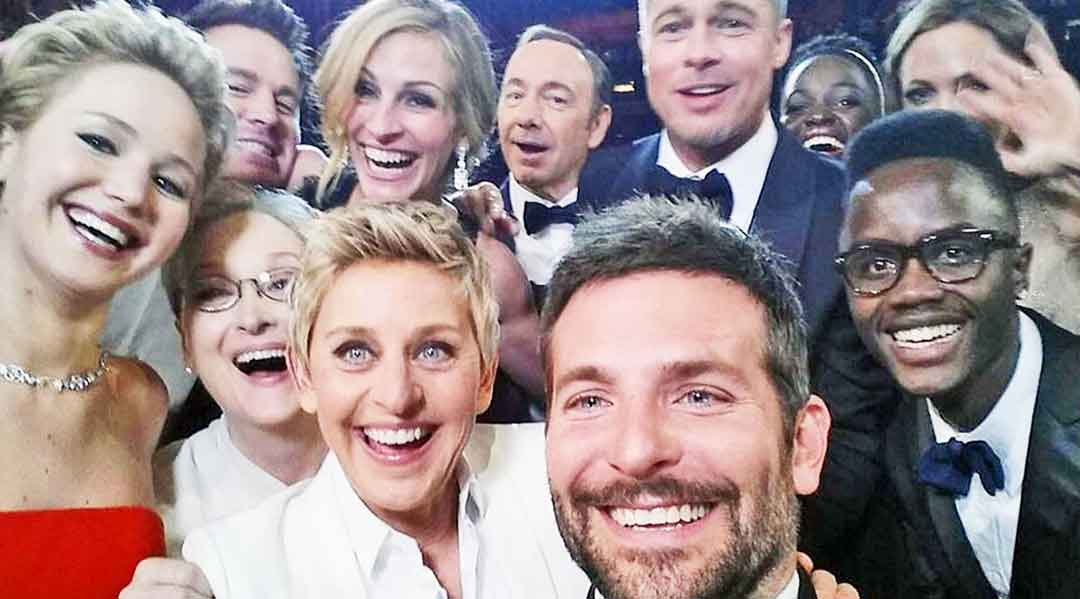

In [29]:
'''
Detect Domain-specific Content - remote
This example detects celebrites and landmarks in remote images.
'''
print("===== Detect Domain-specific Content - remote =====")
# URL of one or more celebrities
remote_image_url_celebs = "https://www.piplum.com/wp-content/uploads/2019/04/celebrities-group-selfie-hollywood.jpg"
# Call API with content type (celebrities) and URL
detect_domain_results_celebs_remote = computervision_client.analyze_image_by_domain("celebrities", remote_image_url_celebs)

# Print detection results with name
print("Celebrities in the remote image:")
if len(detect_domain_results_celebs_remote.result["celebrities"]) == 0:
    print("No celebrities detected.")
else:
    for celeb in detect_domain_results_celebs_remote.result["celebrities"]:
        print(celeb["name"])

===== Detect Domain-specific Content - remote =====
Celebrities in the remote image:
Bradley Cooper


## 4. Detecting Faces
The API can also identify faces, where they are located, and estimate the ages.


Using the same image as above for this example.

In [30]:
'''
Detect Faces - remote
This example detects faces in a remote image, gets their gender and age, 
and marks them with a bounding box.
'''
print("===== Detect Faces - remote =====")
# Get an image with faces
remote_image_url_faces = "https://www.piplum.com/wp-content/uploads/2019/04/celebrities-group-selfie-hollywood.jpg"
#"https://raw.githubusercontent.com/Azure-Samples/cognitive-services-sample-data-files/master/ComputerVision/Images/faces.jpg"
# Select the visual feature(s) you want.
remote_image_features = ["faces"]
# Call the API with remote URL and features
detect_faces_results_remote = computervision_client.analyze_image(remote_image_url_faces, remote_image_features)

# Print the results with gender, age, and bounding box
print("Faces in the remote image: ")
if (len(detect_faces_results_remote.faces) == 0):
    print("No faces detected.")
else:
    for face in detect_faces_results_remote.faces:
        print("'{}' of age {} at location {}, {}, {}, {}".format(face.gender, face.age, \
        face.face_rectangle.left, face.face_rectangle.top, \
        face.face_rectangle.left + face.face_rectangle.width, \
        face.face_rectangle.top + face.face_rectangle.height))

===== Detect Faces - remote =====
Faces in the remote image: 
'Male' of age 39 at location 526, 331, 763, 568
'Female' of age 33 at location 307, 304, 484, 481
'Female' of age 24 at location 37, 108, 205, 276
'Female' of age 33 at location 179, 246, 332, 399
'Female' of age 39 at location 320, 59, 454, 193
'Male' of age 45 at location 632, 0, 772, 126
'Male' of age 34 at location 206, 63, 319, 176
'Male' of age 56 at location 481, 70, 582, 171


## Identify Tags in an image
Using an image of my dog as an example we can see all of the items that it tags, including identifying the breed of my dog (Golden Retriever).

In [ ]:
local_image_path = "/content/2021-02-02 015.JPG"

In [ ]:
'''
Tag an Image - local
This example returns a tag (key word) for each thing in the image.
'''
print("===== Tag an Image - local =====")
# Open local image file
local_image = open(local_image_path, "rb")
# Call API local image
tags_result_local = computervision_client.tag_image_in_stream(local_image)

# Print results with confidence score
print("Tags in the local image: ")
if (len(tags_result_local.tags) == 0):
    print("No tags detected.")
else:
    for tag in tags_result_local.tags:
        print("'{}' with confidence {:.2f}%".format(tag.name, tag.confidence * 100))
print()
'''
END - Tag an Image - local
'''

===== Tag an Image - local =====
Tags in the local image: 
'animal' with confidence 98.97%
'dog breed' with confidence 98.78%
'mammal' with confidence 98.38%
'dog' with confidence 98.24%
'pet' with confidence 95.17%
'small greek domestic dog' with confidence 90.53%
'golden retriever' with confidence 89.19%
'sporting group' with confidence 86.20%
'akbash dog' with confidence 86.06%
'companion dog' with confidence 85.62%
'livestock guardian dog' with confidence 84.95%
'ground' with confidence 82.92%
'person' with confidence 61.15%
'retriever' with confidence 44.62%



'\nEND - Tag an Image - local\n'